In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import shap

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import  MinMaxScaler, Binarizer 
from sklearn.metrics import accuracy_score, f1_score, recall_score,precision_score,roc_auc_score, auc
from sklearn.metrics import precision_recall_curve,roc_curve,confusion_matrix

import matplotlib as mpl
plt.rc('font', family='Malgun Gothic') 
mpl.rcParams['axes.unicode_minus'] = False
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [18]:
def eval(test,pred):
    acc = accuracy_score(test,pred)
    f1 = f1_score(test,pred)
    precision = precision_score(test,pred)
    recall = recall_score(test,pred)
    print('##############\n',confusion_matrix(test,pred),
    "############\n",f'acc_score: {acc}\n f1_score: {f1} \n precision: {precision} \n recall: {recall}')

## 임계값 =[] 리스트생성 후 for 구문
def get_eval_by_threshold(y_test , pred_proba_c1, thresholds=[0.5,0.52,0.54,0.56,0.58,0.6,0.62]):
    # thresholds list객체내의 값을 차례로 iteration하면서 Evaluation 수행.
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1) 
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:',custom_threshold)
        eval(y_test , custom_predict)


def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    

## roc curve_plot    
def roc_curve_plot(y_test,pred_proba):
    fprs, tprs, thresholds = roc_curve(y_test,pred_proba) ## 입력시 1레이블 컬럼만 추출
    
    # Roc curve를 plot 곡선으로 기름
    plt.plot(fprs,tprs,label='ROC')
    ## 가운데 대각선 직선을 그림
    plt.plot([0,1],[0,1],"k--",label="ramdom")
    
    ## fpr x축을 scale을 0.1단위로 변경 x,y축 명 설정
    start,end = plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('FPR(1-sensitivity)')
    plt.ylabel('TPR(recall)')
    plt.legend()
    plt.show()

def plot_pr_auc_curve(y_true, y_pred_proba):
    # Calculate precision, recall and threshold values
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
    # Calculate PR-AUC score
    pr_auc = auc(recall, precision)
    # Plot the PR-AUC curve
    plt.plot(recall, precision, label=f'PR-AUC = {pr_auc:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PR-AUC Curve')
    plt.legend()
    plt.show()

def get_pr_auc_score(y_true, y_pred_proba):
    # Calculate precision, recall and threshold values
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
    # Calculate PR-AUC score
    pr_auc = auc(recall, precision)
    return pr_auc

In [19]:
#  로우 데이터
최종_col = ['abs(영업현금흐름-당기순이익)/매출액','금융비용부담률','WW지수' ,'누적수익성비율', 'TMD','순운전자본비율']

train = pd.read_csv("./datasets/전처리완료/코스닥_train원본.csv",index_col=0)
x_train = train[최종_col]
y_train = train['target_3']

test =  pd.read_csv("./datasets/전처리완료/코스닥_test원본.csv",index_col=0)
x_test = test[최종_col]
y_test = test['target_3']

In [20]:
lr=LogisticRegression(C=1,max_iter=170,penalty='l2',solver='lbfgs',random_state=1)
lr.fit(x_train,y_train)
pred = lr.predict(x_test)
proba_lr = lr.predict_proba(x_test)[:,1].reshape(-1,1)
 
print("임계값 조정: 0",eval(y_test, pred))
print("임계값 조정: 0.39", get_eval_by_threshold(y_test, proba_lr, [0.39]))


##############
 [[2466   11]
 [  22   50]] ############
 acc_score: 0.9870537465672813
 f1_score: 0.7518796992481204 
 precision: 0.819672131147541 
 recall: 0.6944444444444444
임계값 조정: 0 None
임곗값: 0.39
##############
 [[2461   16]
 [  20   52]] ############
 acc_score: 0.9858768144370341
 f1_score: 0.7428571428571428 
 precision: 0.7647058823529411 
 recall: 0.7222222222222222
임계값 조정: 0.39 None


---
# proba 생성

In [21]:
# pd.set_option("display.max.columns", None)
pd.reset_option("display.max.columns", None)
df = pd.concat([train, test], axis=0).reset_index(drop=True)

In [22]:
pd.DataFrame(data=lr.coef_, columns= lr.feature_names_in_)

,abs(영업현금흐름-당기순이익)/매출액,금융비용부담률,WW지수,누적수익성비율,TMD,순운전자본비율
0,2.516517,0.077222,0.179561,-1.360173,0.647083,-0.016069


In [23]:
print(lr.intercept_)

[4.10455839]


In [24]:
# LR

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

df["Z"] = (df["abs(영업현금흐름-당기순이익)/매출액"]*2.516516) + (df["금융비용부담률"]*0.077222) + (df["WW지수"]*0.179561)+(df["누적수익성비율"]*-1.360175) + (df["TMD"]*0.647083) + (df["순운전자본비율"]*-0.016068)+ 4.10454281

df["proba"] = sigmoid(df["Z"]) *100
df["proba"].describe()


count    7059.000000
mean        3.701287
std        13.612287
min         0.007902
25%         0.112021
50%         0.383212
75%         1.462093
max       100.000000
Name: proba, dtype: float64

---
최적절사점(Cutoff –point)
= 
부도기업수×정상기업수 판별점수평균 + (정상기업수×부도기업판별점수평균)
(정상기업수+부도기업수)


In [25]:
df_12 = df[df["회계년도"] == 2012].reset_index(drop=True)
df_13 = df[df["회계년도"] == 2013].reset_index(drop=True)
df_14 = df[df["회계년도"] == 2014].reset_index(drop=True)
df_15 = df[df["회계년도"] == 2015].reset_index(drop=True)
df_16 = df[df["회계년도"] == 2016].reset_index(drop=True)
df_17 = df[df["회계년도"] == 2017].reset_index(drop=True)
df_18 = df[df["회계년도"] == 2018].reset_index(drop=True)
df_19 = df[df["회계년도"] == 2019].reset_index(drop=True)
df_20 = df[df["회계년도"] == 2020].reset_index(drop=True)
df_21 = df[df["회계년도"] == 2021].reset_index(drop=True)

print("------------------데이터 프레임 행 수")
print(len(df_12.index))
print(len(df_13.index))
print(len(df_14.index))
print(len(df_15.index))
print(len(df_16.index))
print(len(df_17.index))
print(len(df_18.index))
print(len(df_19.index))
print(len(df_20.index))
print(len(df_21.index))

------------------데이터 프레임 행 수
592
583
629
648
664
674
720
816
853
880


In [26]:
df_ls = [df_12, df_13, df_14, df_15, df_16, df_17, df_18, df_19, df_20, df_21]

임계_ls = []
for i in df_ls:
    정상기업점수평균 = np.mean(i[i["target_3"]==0]["proba"])
    부실기업점수평균 = np.mean(i[i["target_3"]==1]["proba"])

    정상기업수 = len(i[i["target_3"]==0].index)
    부실기업수 = len(i[i["target_3"]==1].index)

    임계점 = ((부실기업수 * 정상기업점수평균) + (정상기업수 * 부실기업점수평균)) / (정상기업수 + 부실기업수)
    임계_ls.append(임계점)



임계_df =pd.DataFrame({"임계_ls":임계_ls}, index=["2012", "2013","2014","2015","2016","2017","2018","2019","2020","2021"])
임계_df



,임계_ls
2012,53.915268
2013,50.749446
2014,60.916631
2015,49.118718
2016,45.349513
2017,38.867003
2018,49.290376
2019,67.377959
2020,65.603629
2021,76.601703


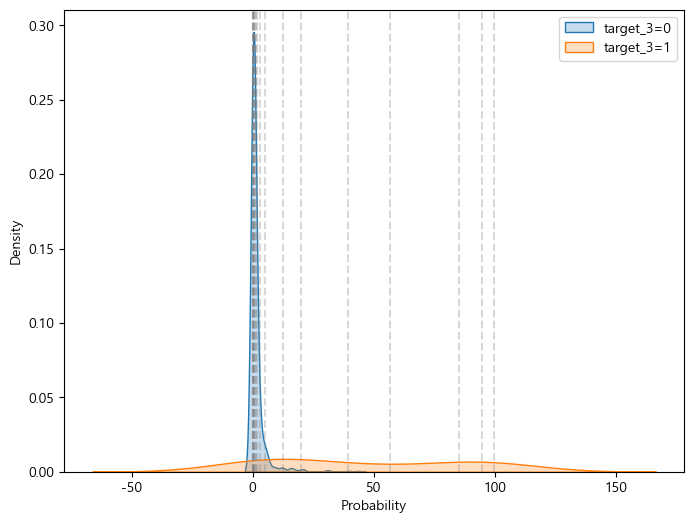

In [27]:
def visualize_percentiles_seaborn(df, target_col, proba_col, percentiles):
    target_values = df[target_col].unique()
    fig, ax = plt.subplots(figsize=(8,6))

    for value in target_values:
        proba = df[df[target_col]==value][proba_col]
        for percentile in percentiles:
            proba_percentile = np.percentile(proba, percentile)
            ax.axvline(x=proba_percentile, color='gray', linestyle='--', alpha=0.3)
        sns.kdeplot(proba, shade=True, ax=ax, label=f"{target_col}={value}")

    ax.set_xlabel("Probability")
    ax.set_ylabel("Density")
    ax.legend()
    plt.show()

visualize_percentiles_seaborn(df_16, "target_3", "proba", [10,20,30,40,50,60,70,80,90])


Text(0.5, 0, '')

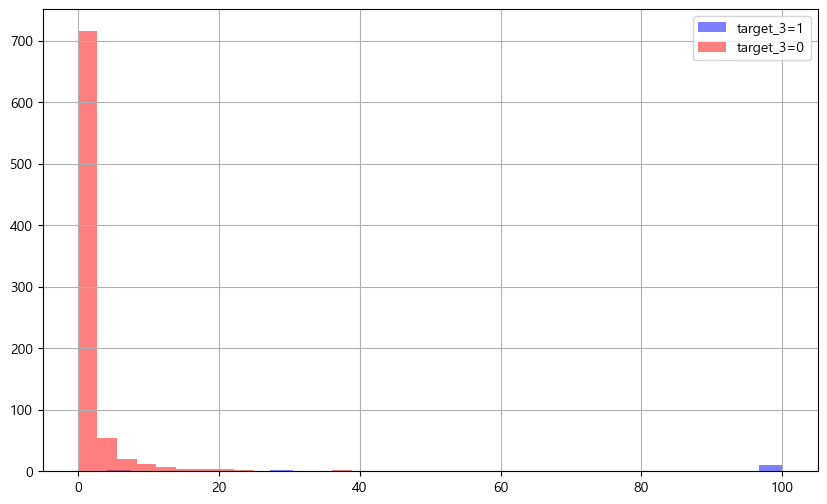

In [28]:
plt.figure(figsize=(10,6))
df_20[df_20['target_3']==1]['proba'].hist(alpha=0.5,color='blue',
                                              bins=30,label='target_3=1')
df_20[df_20['target_3']==0]['proba'].hist(alpha=0.5,color='red',
                                              bins=30,label='target_3=0')
plt.legend()
plt.xlabel('')

---
## 전체 지수 만들기

임계_ls    100.0
Name: 2012, dtype: float64 임계_ls    77.178914
dtype: float64 임계_ls    87.492019
dtype: float64 임계_ls    51.251934
dtype: float64 임계_ls    44.749516
dtype: float64 임계_ls    38.178542
dtype: float64 임계_ls    60.029135
dtype: float64 임계_ls    116.401867
dtype: float64 임계_ls    83.744599
dtype: float64 임계_ls    74.973935
dtype: float64


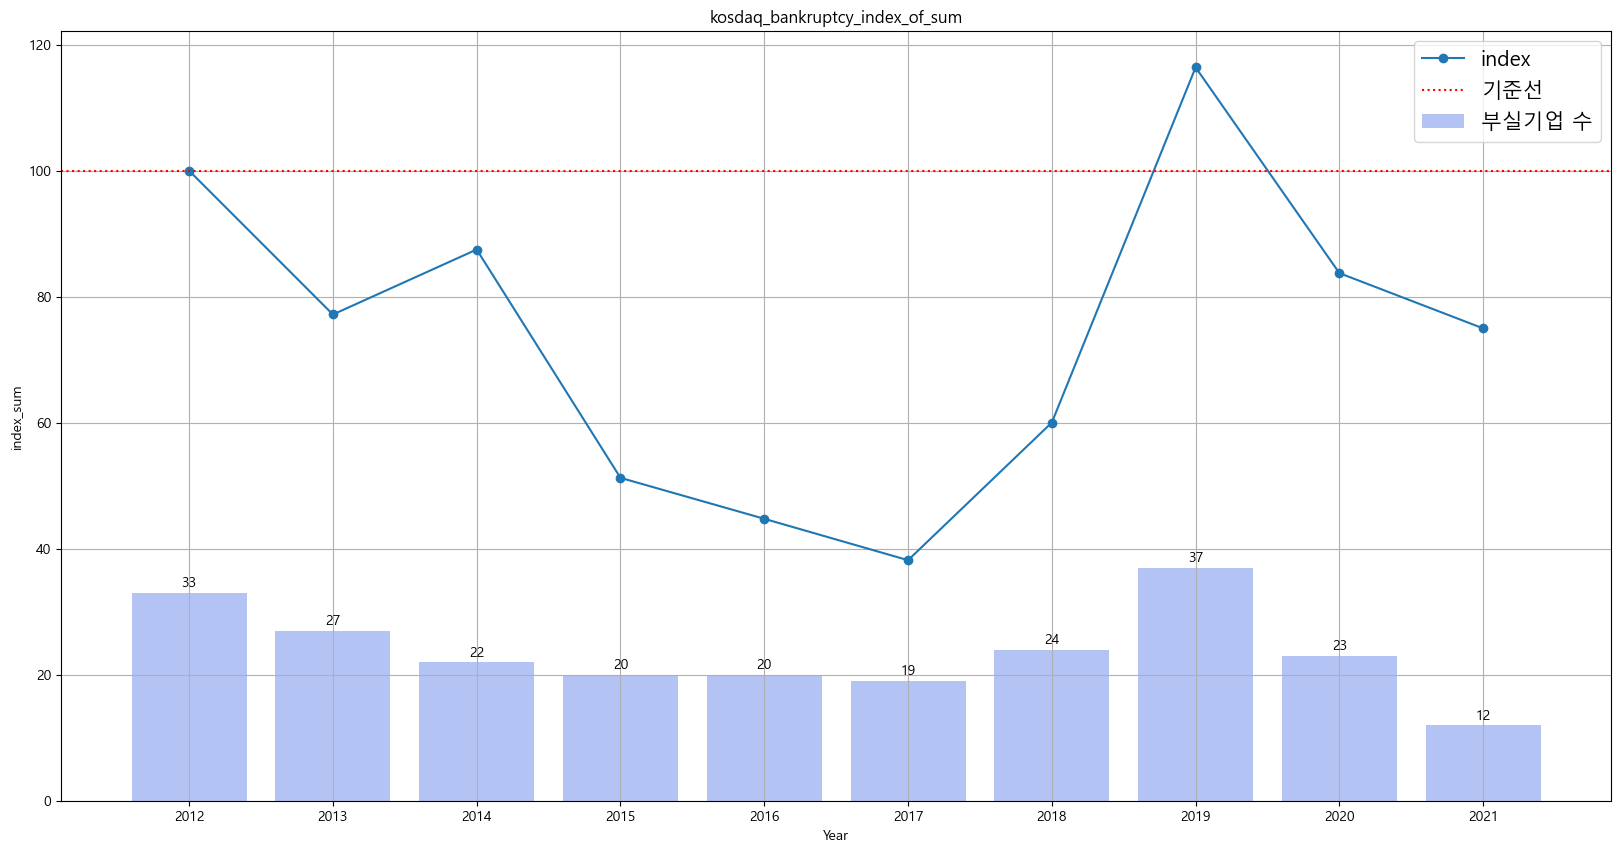

In [29]:
# # 각 연도의 데이터 수 계산
n_12 = len(df_12)
n_13 = len(df_13)
n_14 = len(df_14)
n_15 = len(df_15)
n_16 = len(df_16)
n_17 = len(df_17)
n_18 = len(df_18)
n_19 = len(df_19)
n_20 = len(df_20)
n_21 = len(df_21)

# 해당 년도 전체 기업 프로바 합계

sum_12proba =  df_12["proba"].sum() * 임계_df.iloc[0] 
sum_13proba =  df_13["proba"].sum() * 임계_df.iloc[1]
sum_14proba =  df_14["proba"].sum() * 임계_df.iloc[2] 
sum_15proba =  df_15["proba"].sum() * 임계_df.iloc[3] 
sum_16proba =  df_16["proba"].sum() * 임계_df.iloc[4] 
sum_17proba =  df_17["proba"].sum() * 임계_df.iloc[5] 
sum_18proba =  df_18["proba"].sum() * 임계_df.iloc[6] 
sum_19proba =  df_19["proba"].sum() * 임계_df.iloc[7] 
sum_20proba =  df_20["proba"].sum() * 임계_df.iloc[8] 
sum_21proba =  df_21["proba"].sum() * 임계_df.iloc[9] 


index_12 = ((sum_12proba/n_12)/(sum_12proba/n_12))*100
index_13 = ((sum_13proba/n_13)/(sum_12proba/n_12))*100
index_14 = ((sum_14proba/n_14)/(sum_12proba/n_12))*100
index_15 = ((sum_15proba/n_15)/(sum_12proba/n_12))*100
index_16 = ((sum_16proba/n_16)/(sum_12proba/n_12))*100
index_17 = ((sum_17proba/n_17)/(sum_12proba/n_12))*100
index_18 = ((sum_18proba/n_18)/(sum_12proba/n_12))*100
index_19 = ((sum_19proba/n_19)/(sum_12proba/n_12))*100
index_20 = ((sum_20proba/n_20)/(sum_12proba/n_12))*100
index_21 = ((sum_21proba/n_21)/(sum_12proba/n_12))*100

print(index_12, index_13,index_14,index_15,index_16,index_17,index_18,index_19,index_20,index_21)

# x축, y축 데이터 설정
years = [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
kosdap_bankruptcy_index_of_sum = [index_12,index_13,index_14,index_15,index_16,index_17,index_18,index_19,index_20,index_21]

df_ls = [df_12, df_13, df_14, df_15, df_16, df_17, df_18, df_19, df_20, df_21]

ls = []
for i in df_ls:
    타겟수 = len(np.unique(i[i["target_3"]==1]["회사명"]))
    ls.append(타겟수)

타겟수_df =pd.DataFrame({"ls":ls}, index=["2012", "2013","2014","2015","2016","2017","2018","2019","2020","2021"])
타겟수_df


# 그래프 생성

plt.figure(figsize=(20, 10))
plt.plot(years, kosdap_bankruptcy_index_of_sum, marker='o',label = "index")
plt.xlabel('Year')
plt.bar(years, 타겟수_df["ls"], color = "royalblue",alpha = 0.4,label='부실기업 수')
plt.xticks(np.arange(2012,2022,1))
plt.ylabel('index_sum')
plt.axhline(y=100, color='r', linestyle=':', label='기준선')
plt.title('kosdaq_bankruptcy_index_of_sum')
plt.grid(True)
plt.legend(fontsize=15)

# 각 지점의 값을 그래프에 표시

for i, v in enumerate(타겟수_df["ls"]):
    plt.text(years[i], v+0.5, str(v), ha='center', va='bottom', fontsize=10)

plt.show()


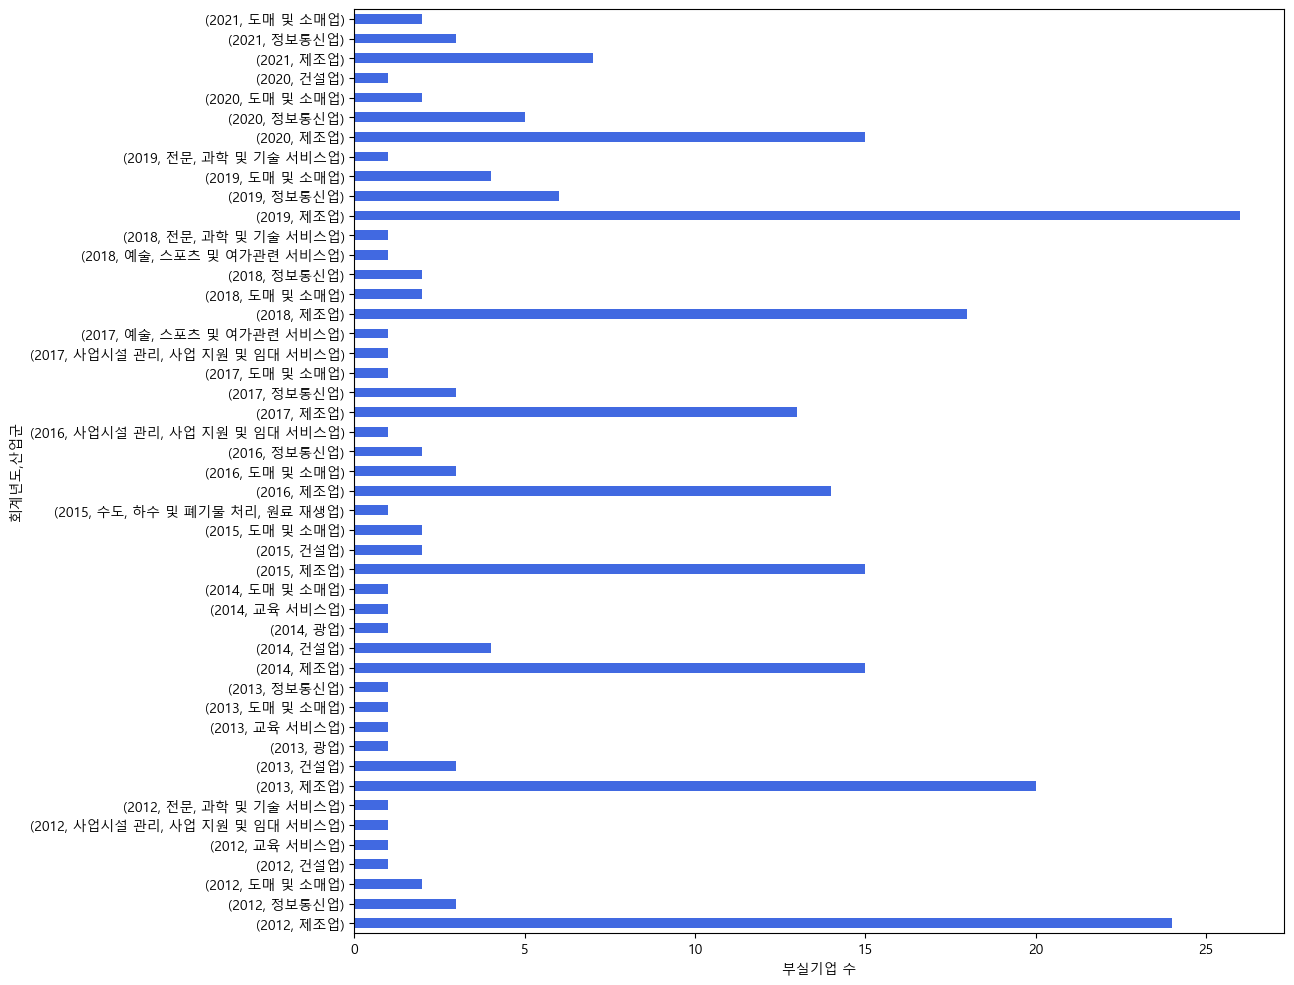

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))
color_list = ['royalblue'] # 색상 리스트 생성
df[df['target_3']==1].groupby(['회계년도'])['산업군'].value_counts().plot.barh(color=color_list)
plt.xlabel('부실기업 수')
plt.show()